Epoch 10/100, Loss: 1.008379
Epoch 20/100, Loss: 0.976909
Epoch 30/100, Loss: 0.948056
Epoch 40/100, Loss: 0.919630
Epoch 50/100, Loss: 0.893827
Epoch 60/100, Loss: 0.869634
Epoch 70/100, Loss: 0.847370
Epoch 80/100, Loss: 0.825140
Epoch 90/100, Loss: 0.803684
Epoch 100/100, Loss: 0.783484


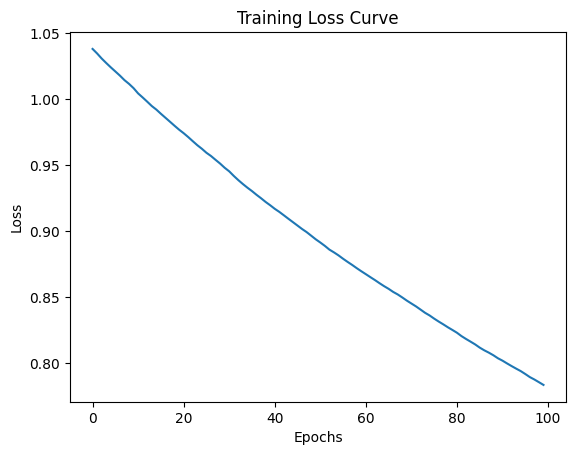

Training Accuracy: 0.4615
Test Accuracy: 0.4649
Predictions: [1 1 1 0 0 0 0 1 1 0]
True labels: [1 0 0 1 1 0 0 0 1 1]


In [3]:
# ================================================================
# Multilayer Perceptron (MLP) - From Scratch (NumPy)
# ================================================================

# -----------------------------
# 1. Imports and Setup
# -----------------------------
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# For reproducibility
np.random.seed(42)

data = pd.read_csv('diabetes.csv')


# -----------------------------
# 2. Activation Functions
# -----------------------------
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_deriv(x):
    s = sigmoid(x)
    return s * (1 - s)

def relu(x):
    return np.maximum(0, x)

def relu_deriv(x):
    return (x > 0).astype(float)


# -----------------------------
# 3. Loss Functions
# -----------------------------
def binary_cross_entropy(y_true, y_pred, eps=1e-12):
    y_pred = np.clip(y_pred, eps, 1 - eps)
    return -np.mean(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))

def binary_cross_entropy_grad(y_true, y_pred, eps=1e-12):
    y_pred = np.clip(y_pred, eps, 1 - eps)
    return (-(y_true / y_pred) + (1 - y_true) / (1 - y_pred)) / y_true.shape[0]


# -----------------------------
# 4. MLP Class Implementation
# -----------------------------
class MLP:
    def __init__(self, layer_sizes, lr=0.001, activation='relu', seed=None):
        """
        layer_sizes: list, e.g., [n_inputs, hidden1, hidden2, ..., n_outputs]
        activation: 'relu' or 'sigmoid' for hidden layers
        """
        if seed:
            np.random.seed(seed)
        self.layer_sizes = layer_sizes
        self.lr = lr
        self.activation_name = activation
        self.params = self._init_weights()

    def _init_weights(self):
        params = {}
        for i in range(len(self.layer_sizes) - 1):
            n_in = self.layer_sizes[i]
            n_out = self.layer_sizes[i + 1]
            params[f"W{i+1}"] = np.random.randn(n_in, n_out) * np.sqrt(2. / n_in)  # He init
            params[f"b{i+1}"] = np.zeros((1, n_out))
        return params

    def _activate(self, x):
        if self.activation_name == 'relu':
            return relu(x)
        elif self.activation_name == 'sigmoid':
            return sigmoid(x)
        else:
            raise ValueError("Unsupported activation")

    def _activate_deriv(self, x):
        if self.activation_name == 'relu':
            return relu_deriv(x)
        elif self.activation_name == 'sigmoid':
            return sigmoid_deriv(x)
        else:
            raise ValueError("Unsupported activation")

    def forward(self, X):
        """Returns intermediate results for backprop"""
        cache = {'A0': X}
        A = X
        for i in range(1, len(self.layer_sizes)):
            W = self.params[f"W{i}"]
            b = self.params[f"b{i}"]
            Z = np.dot(A, W) + b
            cache[f"Z{i}"] = Z
            if i < len(self.layer_sizes) - 1:
                A = self._activate(Z)
            else:
                A = sigmoid(Z)  # output layer for binary
            cache[f"A{i}"] = A
        return cache

    def backward(self, cache, y_true):
        grads = {}
        m = y_true.shape[0]
        L = len(self.layer_sizes) - 1
        A_final = cache[f"A{L}"]

        dA = binary_cross_entropy_grad(y_true, A_final)
        for i in reversed(range(1, L + 1)):
            Z = cache[f"Z{i}"]
            A_prev = cache[f"A{i-1}"]
            W = self.params[f"W{i}"]

            if i == L:
                dZ = dA * sigmoid_deriv(Z)
            else:
                dZ = dA * self._activate_deriv(Z)

            dW = np.dot(A_prev.T, dZ)
            db = np.sum(dZ, axis=0, keepdims=True)
            dA = np.dot(dZ, W.T)

            grads[f"dW{i}"] = dW / m
            grads[f"db{i}"] = db / m

        return grads

    def update(self, grads):
        for i in range(1, len(self.layer_sizes)):
            self.params[f"W{i}"] -= self.lr * grads[f"dW{i}"]
            self.params[f"b{i}"] -= self.lr * grads[f"db{i}"]

    def fit(self, X, y, epochs=100, batch_size=32, verbose=True):
        n_samples = X.shape[0]
        loss_history = []
        for epoch in range(1, epochs + 1):
            idx = np.random.permutation(n_samples)
            X_shuffled = X[idx]
            y_shuffled = y[idx]

            epoch_loss = 0
            for start in range(0, n_samples, batch_size):
                end = start + batch_size
                X_batch = X_shuffled[start:end]
                y_batch = y_shuffled[start:end]

                cache = self.forward(X_batch)
                y_pred = cache[f"A{len(self.layer_sizes)-1}"]
                loss = binary_cross_entropy(y_batch, y_pred)
                grads = self.backward(cache, y_batch)
                self.update(grads)
                epoch_loss += loss * (X_batch.shape[0] / n_samples)

            loss_history.append(epoch_loss)
            if verbose and epoch % 10 == 0:
                print(f"Epoch {epoch}/{epochs}, Loss: {epoch_loss:.6f}")
        return loss_history

    def predict(self, X):
        cache = self.forward(X)
        y_pred = cache[f"A{len(self.layer_sizes)-1}"]
        return (y_pred > 0.5).astype(int)

    def accuracy(self, X, y):
        preds = self.predict(X)
        return np.mean(preds == y)


# -----------------------------
# 5. Dataset Preparation
# -----------------------------
# data = load_breast_cancer()
# data = pd.load_csv('diabetes.csv')
# X = data.data
# y = data.target.reshape(-1, 1)

# Normalize
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# -----------------------------
# 6. Model Training
# -----------------------------
mlp = MLP(layer_sizes=[X_train.shape[1], 64, 16, 1], lr=0.001, activation='relu', seed=42)
loss_history = mlp.fit(X_train, y_train, epochs=100, batch_size=32, verbose=True)

plt.plot(loss_history)
plt.title("Training Loss Curve")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()


# -----------------------------
# 7. Evaluation
# -----------------------------
train_acc = mlp.accuracy(X_train, y_train)
test_acc = mlp.accuracy(X_test, y_test)
print(f"Training Accuracy: {train_acc:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")

# Sample predictions
y_pred = mlp.predict(X_test[:10])
print("Predictions:", y_pred.reshape(-1))
print("True labels:", y_test[:10].reshape(-1))
